# Import libraries

In [1]:

from src.preprocessing.dataLoader_CelebA import get_partitioned_dataloaders, create_subset_loader
from src.preprocessing.dataLoader_vi import SiameseNetworkDataset
from src.ml.own_network import SiameseNetworkOwn
from src.ml.resNet18 import SiameseNetwork
from src.ml.loss_utils import ContrastiveLoss, ArcFaceLoss, MultiSimilarityLoss
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch
import torchvision
import torch.nn.functional as F

# 1. Load the data

In [2]:
import yaml

# Load config from YAML
with open("../config/config.yml", "r") as f:
    config = yaml.safe_load(f)

# Extract sections
PRE = config["PREPROCESSING"]
TRAIN = config["TRAINING_MS"]

# Set constants from preprocessing config
IMAGE_DIR = PRE["image_dir"]
LABEL_FILE = PRE["label_file"]
PARTITION_FILE = PRE["partition_file"]
BATCH_SIZE = 32 #PRE["batch_size"]
M_PER_SAMPLE = PRE["m_per_sample"]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set constants from training config
LR = TRAIN["lr"]
SCHEDULING = TRAIN["scheduling"]
WEIGHT_DECAY = TRAIN["weight_decay"]
NUM_EPOCHS = TRAIN["num_epochs"]
PATIENCE = TRAIN["patience"]
LOSS_TYPE = "multisimilarity"
DATASET_NAME = "celebA"# "celebA" # ATT
NUM_IDENTITY = 200

In [3]:
def plot_all(train_loader):
    # Assuming train_loader uses FilteredCelebADataset with remapped labels

    # Access the underlying dataset from train_loader
    train_dataset = train_loader.dataset

    # Collect one example image per unique label
    unique_labels = sorted(set(train_dataset.labels))
    label_to_img = {}

    for idx, label in enumerate(train_dataset.labels):
        if label not in label_to_img:
            label_to_img[label] = train_dataset[idx][0]  # Assuming dataset[idx] returns (image, label)

    # Plot all unique labels with their example images
    num_labels = len(unique_labels)
    cols = 10
    rows = (num_labels + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    axes = axes.flatten()

    for i, label in enumerate(unique_labels):
        img = label_to_img[label].permute(1, 2, 0).numpy()

        # Denormalize (if your dataset applies normalization)
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        img = img * std + mean
        img = img.clip(0, 1)

        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


In [4]:
if DATASET_NAME == "celebA":
    # Load datasets
    train_loader, val_loader, test_loader = get_partitioned_dataloaders(
        image_dir=IMAGE_DIR,
        label_file=LABEL_FILE,
        partition_file=PARTITION_FILE,
        m_per_sample=M_PER_SAMPLE,
        batch_size=BATCH_SIZE,
        num_identities=NUM_IDENTITY,
        seed=42
    )
    # plot_all(train_loader=train_loader)
else:
    # Load the training dataset
    folder_dataset = datasets.ImageFolder(root="data/v2/data/faces/training/")

    # Resize the images and transform to tensors
    transformation = transforms.Compose([transforms.Resize((100,100)),
                                        transforms.ToTensor()
                                        ])

    # Initialize the network
    siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                            transform=transformation)
    train_loader = DataLoader(siamese_dataset, shuffle=True, num_workers=0, batch_size=BATCH_SIZE)

    # Locate the test dataset and load it into the SiameseNetworkDataset
    folder_dataset_test = datasets.ImageFolder(root="data/v2/data/faces/validation/")
    siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                            transform=transformation)
    val_loader = DataLoader(siamese_dataset, num_workers=0, batch_size=BATCH_SIZE, shuffle=True)

    # Locate the test dataset and load it into the SiameseNetworkDataset
    folder_dataset_test = datasets.ImageFolder(root="data/v2/data/faces/testing/")
    siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                            transform=transformation)
    test_loader = DataLoader(siamese_dataset, num_workers=0, batch_size=1, shuffle=True)

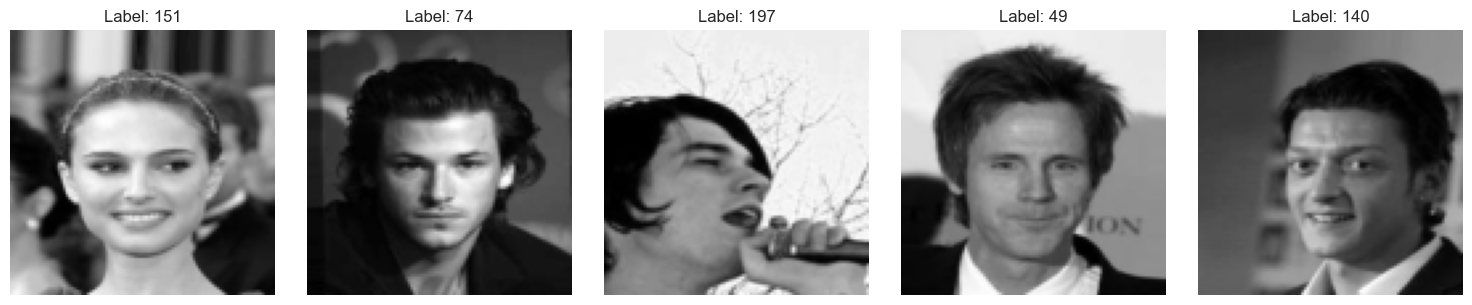

In [5]:
import matplotlib.pyplot as plt
import torch

plt.figure(figsize=(15, 3))

for i in range(5):
    sample = test_loader.dataset[i]
    image, label = sample[0], sample[3]  # image is first, label is fifth

    # Convert image to numpy
    if isinstance(image, torch.Tensor):
        if image.ndim == 3 and image.shape[0] == 1:  # grayscale
            image = image.squeeze().numpy()
            cmap = 'gray'
        elif image.ndim == 3 and image.shape[0] == 3:  # RGB
            image = image.permute(1, 2, 0).numpy()
            cmap = None
        else:
            raise ValueError(f"Unexpected image shape: {image.shape}")
    else:
        cmap = 'gray'

    # Convert label to int
    if isinstance(label, torch.Tensor):
        label = label.item()

    plt.subplot(1, 5, i + 1)
    plt.imshow(image, cmap=cmap)
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [6]:
num_batches_val = len(val_loader)
print(f"Number of batches in validation dataloader: {num_batches_val}")
num_samples_train = len(train_loader.dataset)
num_batches_train = len(train_loader)
print(f"Training samples: {num_samples_train}, Batches: {num_batches_train}")

Number of batches in validation dataloader: 19
Training samples: 2803, Batches: 87


# Create the model

In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = SiameseNetwork().to(DEVICE)
#net = SiameseNetworkOwn().to(DEVICE)

# Train Model

In [8]:
loss_type = LOSS_TYPE

if loss_type == "contrastive":
    criterion = ContrastiveLoss(margin=20).to(DEVICE)
elif loss_type == "arcface":
    criterion = ArcFaceLoss(num_classes=NUM_IDENTITY, embedding_size=256).to(DEVICE)
elif loss_type == "multisimilarity":
    import pytorch_metric_learning.losses as losses
    criterion = losses.MultiSimilarityLoss(alpha=70, beta=40, base=0.5).to(DEVICE)


In [9]:
# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [10]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)                      # Python random module
    np.random.seed(seed)                   # NumPy
    torch.manual_seed(seed)                # PyTorch CPU
    torch.cuda.manual_seed(seed)           # PyTorch GPU (single GPU)
    torch.cuda.manual_seed_all(seed)       # PyTorch GPU (all GPUs if you use DataParallel)
    
    # For deterministic behavior (may be slower)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Call this once at the start of your script (before model init and training)
# set_seed(1234)

In [11]:
import mlflow
import mlflow.pytorch

# Set the experiment path (this can be a local or remote artifact URI)
mlflow.set_tracking_uri("../mlruns")
mlflow.set_experiment(f"Siamese_Network_{DATASET_NAME}_{LOSS_TYPE}")


<Experiment: artifact_location='file:C:/Users/ehait/PycharmProjects/RAML/mlruns/150639580473445161', creation_time=1750436823230, experiment_id='150639580473445161', last_update_time=1750436823230, lifecycle_stage='active', name='Siamese_Network_celebA_multisimilarity', tags={}>

Epoch 70/70 [Training]: 100%|██████████| 87/87 [00:06<00:00, 14.47it/s, Train Loss=0.0334, Val Loss=0.0347]


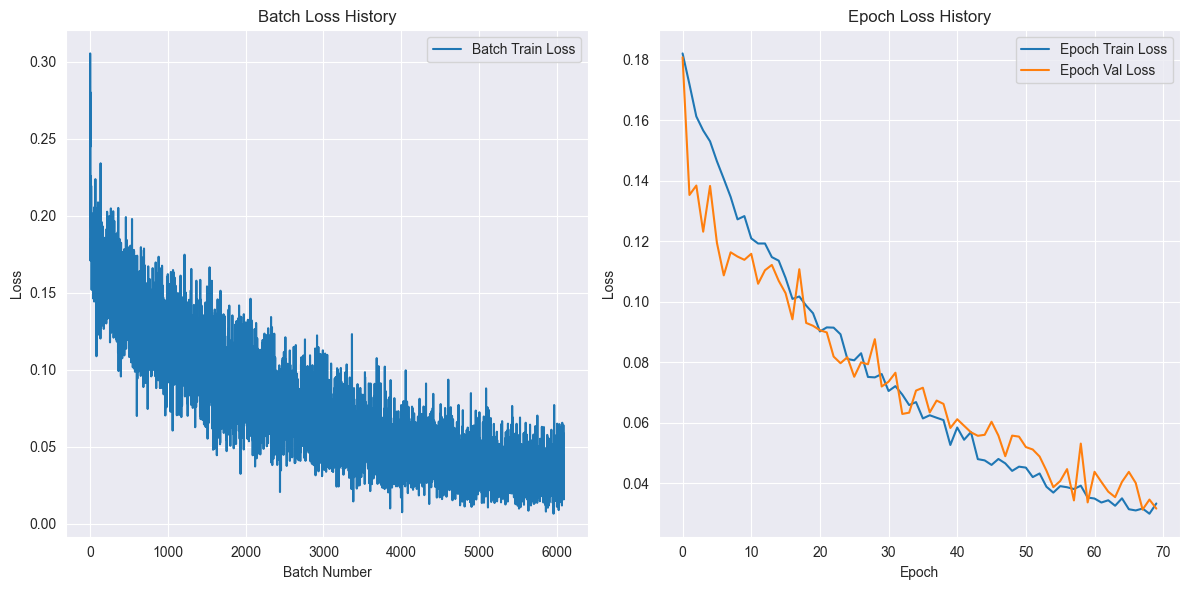

2025/06/20 18:37:14 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/20 18:37:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [12]:
from tqdm import tqdm
import matplotlib.pyplot as plt

NUM_EPOCHS = 70
LEARNING_RATE = 0.0005
WEIGHT_DECAY = 1e-4

# Initialize optimizer and scheduler
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Initialize loss history lists
batch_loss_history = []
batch_val_loss_history = []
epoch_loss_history = []
epoch_val_loss_history = []

# ---------- Start MLflow Run ----------
with mlflow.start_run(run_name=f"{LOSS_TYPE}_{DATASET_NAME}"):

    # Log hyperparameters
    mlflow.log_param("num_epochs", NUM_EPOCHS)
    mlflow.log_param("learning_rate", LEARNING_RATE)
    mlflow.log_param("loss_type", loss_type)
    mlflow.log_param("dataset", DATASET_NAME)

    for epoch in range(NUM_EPOCHS):
        net.train()
        cum_loss = 0

        pbar = tqdm(enumerate(train_loader, 0), total=len(train_loader),
                    desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} [Training]", leave=True)

        for i, (img0, img1, label, label0, label1) in pbar:
            img0, img1, label = img0.to(DEVICE), img1.to(DEVICE), label.to(DEVICE)
            label0, label1 = label0.to(DEVICE), label1.to(DEVICE)

            optimizer.zero_grad()
            output1, output2 = net(img0, img1)

            if loss_type == "contrastive":
                loss = criterion(output1, output2, label)
            elif loss_type == "multisimilarity":
                embeddings = torch.cat([output1, output2])
                labels = torch.cat([label0, label1])
                loss = criterion(embeddings, labels)
            elif loss_type == "arcface":
                loss = criterion(output1, output2, label0, label1)

            loss.backward()
            optimizer.step()

            cum_loss += loss.item()
            batch_loss_history.append(loss.item())
            avg_train_loss = cum_loss / (i + 1)

            pbar.set_postfix({
                'Train Loss': f"{avg_train_loss:.4f}",
                'Val Loss': f"{epoch_val_loss_history[-1]:.4f}" if epoch_val_loss_history else '--'
            })

        epoch_loss_history.append(avg_train_loss)

        # ---------- Validation ----------
        net.eval()
        val_loss = 0.0
        with torch.no_grad():
            for img0, img1, label, label0, label1 in val_loader:
                img0, img1, label = img0.to(DEVICE), img1.to(DEVICE), label.to(DEVICE)
                label0, label1 = label0.to(DEVICE), label1.to(DEVICE)

                output1, output2 = net(img0, img1)

                if loss_type == "contrastive":
                    loss = criterion(output1, output2, label)
                elif loss_type == "multisimilarity":
                    embeddings = torch.cat([output1, output2])
                    labels = torch.cat([label0, label1])
                    loss = criterion(embeddings, labels)
                elif loss_type == "arcface":
                    loss = criterion(output1, output2, label0, label1)

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        epoch_val_loss_history.append(avg_val_loss)

        # ---------- Log Epoch Metrics ----------
        mlflow.log_metric("epoch_train_loss", avg_train_loss, step=epoch)
        mlflow.log_metric("epoch_val_loss", avg_val_loss, step=epoch)

        pbar.set_postfix({
            'Train Loss': f"{avg_train_loss:.4f}",
            'Val Loss': f"{avg_val_loss:.4f}"
        })
        pbar.close()

        # Optional: scheduler.step()

    # ---------- Plot and Log Losses ----------
    plt.figure(figsize=(12, 6))

    # Batch loss plot
    if batch_loss_history:
        plt.subplot(1, 2, 1)
        plt.plot(batch_loss_history, label='Batch Train Loss')
        if batch_val_loss_history:
            plt.plot(batch_val_loss_history, label='Batch Val Loss')
        plt.title('Batch Loss History')
        plt.xlabel('Batch Number')
        plt.ylabel('Loss')
        plt.legend()

    # Epoch loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epoch_loss_history, label='Epoch Train Loss')
    plt.plot(epoch_val_loss_history, label='Epoch Val Loss')
    plt.title('Epoch Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plot_path = "../loss_plot.png"
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)
    plt.show()

    # ---------- Save Model Checkpoint ----------
    checkpoint_path = f"checkpoint_{DATASET_NAME}_{LOSS_TYPE}.pth"
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': epoch_loss_history,
        'val_loss': epoch_val_loss_history,
        'batch_train_loss': batch_loss_history,
        'batch_val_loss': batch_val_loss_history if 'batch_val_loss_history' in locals() else None,
    }, checkpoint_path)
    
    mlflow.log_artifact(checkpoint_path)

    # ---------- Log Full Model ----------
    mlflow.pytorch.log_model(net, artifact_path="../models")

✅ Average Positive Euclidean Distance: 5.0322
✅ Average Negative Euclidean Distance: 6.9674
✅ Average Positive Cosine Distance: 0.4010
✅ Average Negative Cosine Distance: 0.7719


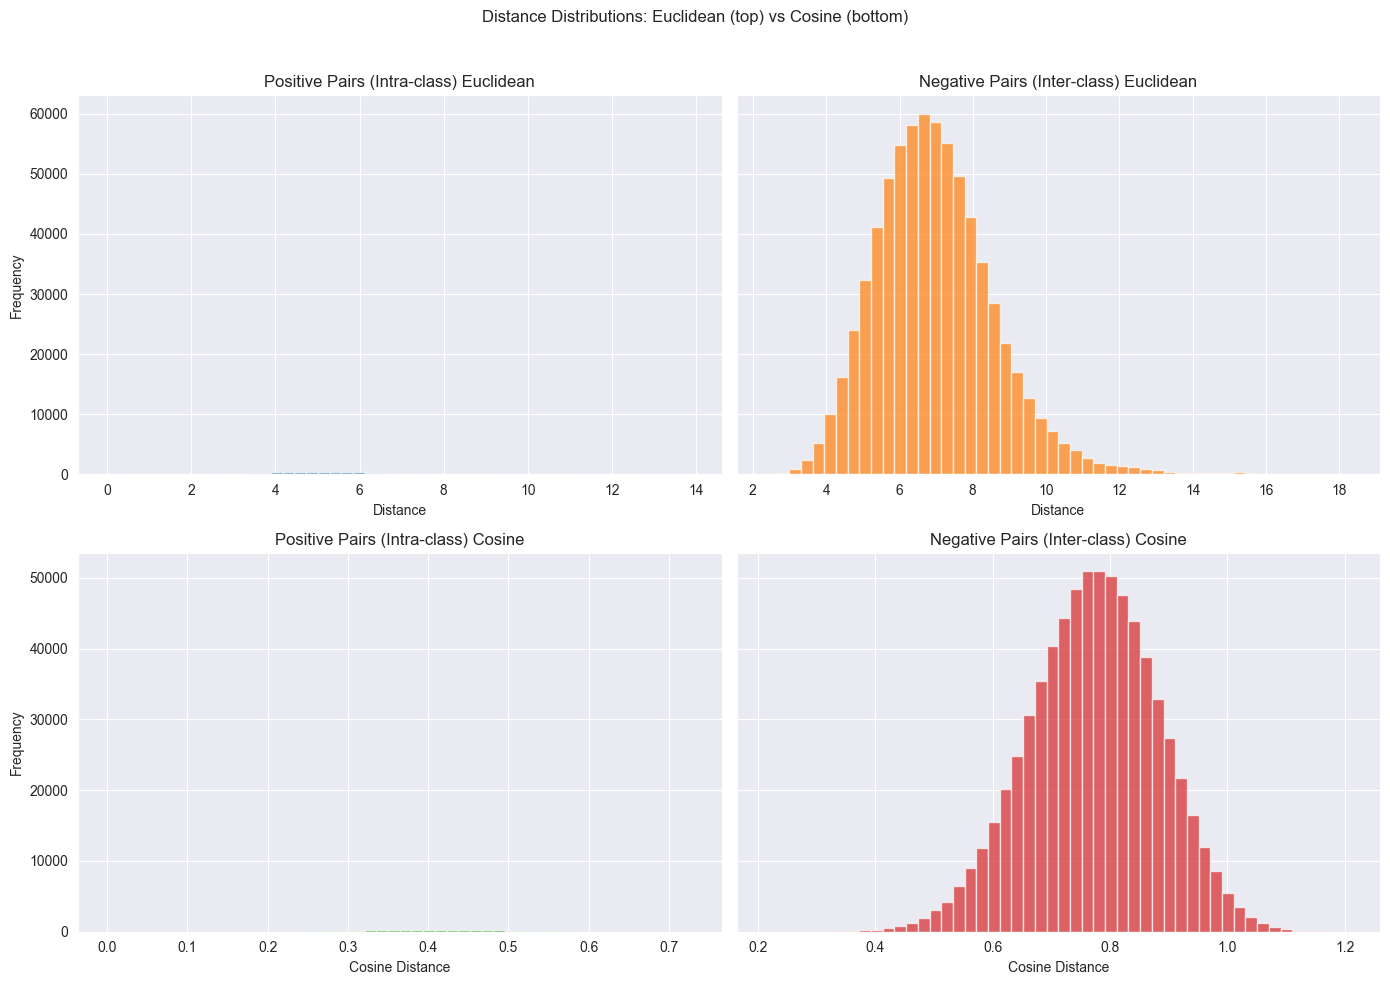

In [13]:
from collections import defaultdict
from itertools import combinations
import torch.nn.functional as F
import matplotlib.pyplot as plt

net.eval()
all_embeddings = []
all_labels = []

with torch.no_grad():
    for img0, img1, _, label0, label1 in val_loader:
        img0, img1 = img0.to(DEVICE), img1.to(DEVICE)
        label0, label1 = label0.to(DEVICE), label1.to(DEVICE)
        output1, output2 = net(img0, img1)

        all_embeddings.append(torch.cat([output1, output2]))
        all_labels.append(torch.cat([label0, label1]))

all_embeddings = torch.cat(all_embeddings)  # shape: [N, D]
all_labels = torch.cat(all_labels)          # shape: [N]

# Group embeddings by class
class_to_embeddings = defaultdict(list)
for emb, label in zip(all_embeddings, all_labels):
    class_to_embeddings[label.item()].append(emb)
for key in class_to_embeddings:
    class_to_embeddings[key] = torch.stack(class_to_embeddings[key])

# Helper function for cosine distance (1 - cosine similarity)
def cosine_distance(x, y):
    cos_sim = F.cosine_similarity(x, y)
    return 1 - cos_sim

# -----------------------------
# Euclidean distances
# -----------------------------
positive_dists_euc = []
negative_dists_euc = []

for emb_list in class_to_embeddings.values():
    if len(emb_list) < 2:
        continue
    for i, j in combinations(range(len(emb_list)), 2):
        dist = F.pairwise_distance(emb_list[i].unsqueeze(0), emb_list[j].unsqueeze(0))
        positive_dists_euc.append(dist.item())

label_keys = list(class_to_embeddings.keys())
for i in range(len(label_keys)):
    for j in range(i + 1, len(label_keys)):
        emb_i = class_to_embeddings[label_keys[i]]
        emb_j = class_to_embeddings[label_keys[j]]
        for e1 in emb_i:
            for e2 in emb_j:
                dist = F.pairwise_distance(e1.unsqueeze(0), e2.unsqueeze(0))
                negative_dists_euc.append(dist.item())

# -----------------------------
# Cosine distances
# -----------------------------
positive_dists_cos = []
negative_dists_cos = []

for emb_list in class_to_embeddings.values():
    if len(emb_list) < 2:
        continue
    for i, j in combinations(range(len(emb_list)), 2):
        dist = cosine_distance(emb_list[i].unsqueeze(0), emb_list[j].unsqueeze(0))
        positive_dists_cos.append(dist.item())

for i in range(len(label_keys)):
    for j in range(i + 1, len(label_keys)):
        emb_i = class_to_embeddings[label_keys[i]]
        emb_j = class_to_embeddings[label_keys[j]]
        for e1 in emb_i:
            for e2 in emb_j:
                dist = cosine_distance(e1.unsqueeze(0), e2.unsqueeze(0))
                negative_dists_cos.append(dist.item())

# -----------------------------
# Calculate averages
# -----------------------------
def avg(lst):
    return sum(lst) / len(lst) if lst else 0.0

avg_pos_euc = avg(positive_dists_euc)
avg_neg_euc = avg(negative_dists_euc)
avg_pos_cos = avg(positive_dists_cos)
avg_neg_cos = avg(negative_dists_cos)

print(f"✅ Average Positive Euclidean Distance: {avg_pos_euc:.4f}")
print(f"✅ Average Negative Euclidean Distance: {avg_neg_euc:.4f}")
print(f"✅ Average Positive Cosine Distance: {avg_pos_cos:.4f}")
print(f"✅ Average Negative Cosine Distance: {avg_neg_cos:.4f}")

# Log metrics
mlflow.log_metric("avg_positive_euclidean_distance", avg_pos_euc)
mlflow.log_metric("avg_negative_euclidean_distance", avg_neg_euc)
mlflow.log_metric("avg_positive_cosine_distance", avg_pos_cos)
mlflow.log_metric("avg_negative_cosine_distance", avg_neg_cos)

# -----------------------------
# Plotting
# -----------------------------
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharey='row')

# Euclidean distances histograms
axs[0, 0].hist(positive_dists_euc, bins=50, color='tab:blue', alpha=0.7)
axs[0, 0].set_title('Positive Pairs (Intra-class) Euclidean')
axs[0, 0].set_xlabel('Distance')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].grid(True)

axs[0, 1].hist(negative_dists_euc, bins=50, color='tab:orange', alpha=0.7)
axs[0, 1].set_title('Negative Pairs (Inter-class) Euclidean')
axs[0, 1].set_xlabel('Distance')
axs[0, 1].grid(True)

# Cosine distances histograms
axs[1, 0].hist(positive_dists_cos, bins=50, color='tab:green', alpha=0.7)
axs[1, 0].set_title('Positive Pairs (Intra-class) Cosine')
axs[1, 0].set_xlabel('Cosine Distance')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].grid(True)

axs[1, 1].hist(negative_dists_cos, bins=50, color='tab:red', alpha=0.7)
axs[1, 1].set_title('Negative Pairs (Inter-class) Cosine')
axs[1, 1].set_xlabel('Cosine Distance')
axs[1, 1].grid(True)

plt.suptitle("Distance Distributions: Euclidean (top) vs Cosine (bottom)")
plt.tight_layout(rect=[0, 0, 1, 0.96])

dist_plot_path = "../distance_histogram_euclidean_cosine.png"
plt.savefig(dist_plot_path)
mlflow.log_artifact(dist_plot_path)
plt.show()


In [14]:
separation_ratio = avg_inter / avg_intra
print(f"🔍 Inter/Intra-Class Distance Ratio: {separation_ratio:.2f}")
# ---------- Log to MLflow ----------
mlflow.log_metric("separation_ratio", separation_ratio)

NameError: name 'avg_inter' is not defined

In [ ]:
! pip install umap-learn

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import mlflow
import os

# Set seed for reproducibility
np.random.seed(42)

# Convert tensors to NumPy arrays
X = all_embeddings.cpu().numpy()
y = all_labels.cpu().numpy()
unique_labels = np.unique(y)

# Start MLflow run
with mlflow.start_run(run_name="TSNE_Visualizations"):

    def run_tsne(X_filtered, y_filtered, label_count, metric):
        n_samples = X_filtered.shape[0]
        perplexity = min(30, (n_samples - 1) // 3)
        if perplexity < label_count:
            print(f"⚠️ Skipping: Not enough samples ({n_samples}) for {label_count} labels.")
            return

        # Normalize labels for coloring
        label_mapping = {label: idx for idx, label in enumerate(sorted(np.unique(y_filtered)))}
        y_mapped = np.vectorize(label_mapping.get)(y_filtered)

        print(f"▶️ Running t-SNE (metric={metric}, labels={label_count}, perplexity={perplexity})")
        tsne = TSNE(n_components=2, perplexity=perplexity, max_iter=1000, random_state=42, metric=metric)
        X_tsne = tsne.fit_transform(X_filtered)

        # Plot
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_mapped, palette='tab20', s=30, legend='full')
        plt.title(f"t-SNE ({metric.capitalize()} Distance) - {label_count} Labels")
        plt.xlabel("t-SNE 1")
        plt.ylabel("t-SNE 2")
        plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.grid(True)

        # Save & log
        fname = f"tsne_{label_count}labels_{metric}.png"
        plt.savefig(fname)
        mlflow.log_artifact(fname)
        plt.close()
        os.remove(fname)

        # Log metrics
        mlflow.log_param(f"perplexity_{label_count}_{metric}", perplexity)

    # Try for 5, 15, 25 label groups
    for label_count in [5, 15, 25]:
        if len(unique_labels) < label_count:
            print(f"⚠️ Only {len(unique_labels)} labels available. Skipping {label_count}.")
            continue

        selected_labels = np.random.choice(unique_labels, size=label_count, replace=False)
        mask = np.isin(y, selected_labels)
        X_filtered = X[mask]
        y_filtered = y[mask]

        # Log which labels were selected
        mlflow.log_param(f"selected_labels_{label_count}", selected_labels.tolist())

        # Run t-SNE for both metrics
        run_tsne(X_filtered, y_filtered, label_count, metric="cosine")
        run_tsne(X_filtered, y_filtered, label_count, metric="euclidean")


In [ ]:

"""
# --- UMAP ---
print("Running UMAP...")
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette='tab10', legend='full', s=30)
plt.title("UMAP Visualization of Embeddings")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()
"""


# TEST

In [15]:
import torch
import torch.nn.functional as F

# Assuming your model class is defined as 'Net' (replace with your actual class)
net = SiameseNetworkOwn().to(DEVICE)
checkpoint = torch.load(f'models/checkpoint_{DATASET_NAME}_{LOSS_TYPE}.pth', map_location=DEVICE)
net.load_state_dict(checkpoint['model_state_dict'])

FileNotFoundError: [Errno 2] No such file or directory: 'models/checkpoint_celebA_multisimilarity.pth'

In [ ]:
import mlflow
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os

# Run 10 times
for run_idx in range(10):
    with mlflow.start_run(run_name=f"Siamese_Pairs_Run_{run_idx + 1}"):
        for i in range(10):
            img1, img2, _, label1, label2 = next(iter(test_loader))

            with torch.no_grad():
                emb1, emb2 = net(img1.to(DEVICE), img2.to(DEVICE))
                euclidean_distance = F.pairwise_distance(emb1, emb2)
                cosine_sim = F.cosine_similarity(emb1, emb2)

            lbl1 = label1[0].cpu().item() if isinstance(label1, torch.Tensor) else label1
            lbl2 = label2[0].cpu().item() if isinstance(label2, torch.Tensor) else label2

            concatenated = torch.cat((img1[0], img2[0]), 2)

            title = (
                f'Label1: {lbl1} | Label2: {lbl2}\n'
                f'Euclidean: {euclidean_distance.item():.2f} | '
                f'Cosine Sim: {cosine_sim.item():.2f}'
            )

            fig, ax = plt.subplots(figsize=(4, 2))
            img_grid = torchvision.utils.make_grid(concatenated)
            np_img = img_grid.numpy().transpose((1, 2, 0))
            ax.imshow(np_img)
            ax.set_title(title, fontsize=9)
            ax.axis('off')

            fname = f"siamese_pair_run{run_idx+1}_{i+1}.png"
            plt.tight_layout()
            plt.savefig(fname)
            mlflow.log_artifact(fname)
            plt.close(fig)
            os.remove(fname)

            mlflow.log_metric(f"euclidean_run{run_idx+1}_pair{i+1}", euclidean_distance.item())
            mlflow.log_metric(f"cosine_sim_run{run_idx+1}_pair{i+1}", cosine_sim.item())


In [ ]:
# CHAT TEST
from collections import defaultdict

# 1. Alle Bilder aus test_dataloader einmalig laden und nach Label gruppieren
label_to_images = defaultdict(list)

for img, _, _, label, _ in test_loader:
    label_to_images[label.item()].append(img)

# 2. Jetzt 20 Paare mit gleichem Label erzeugen
fig, axs = plt.subplots(4, 5, figsize=(12, 8))
axs = axs.flatten()

net.eval()

i = 0
for label, images in label_to_images.items():
    if len(images) < 2:
        continue  # brauchen mindestens 2 Bilder mit gleichem Label

    # Erzeuge z. B. 2 zufällige Bilder dieses Labels
    img1 = images[0].to(DEVICE)
    img2 = images[1].to(DEVICE)

    with torch.no_grad():
        emb1, emb2 = net(img1, img2)
        euclidean_distance = F.pairwise_distance(emb1, emb2)
        cosine_sim = F.cosine_similarity(emb1, emb2)

    img1_gray = img1[0, 0].cpu()
    img2_gray = img2[0, 0].cpu()
    concatenated = torch.cat((img1_gray, img2_gray), dim=1)

    axs[i].imshow(concatenated.numpy(), cmap="gray")
    axs[i].set_title(
        f"Euc: {euclidean_distance.item():.2f}\nCos: {cosine_sim.item():.2f}\nLabel: {label}",
        fontsize=8
    )
    axs[i].axis("off")

    i += 1
    if i >= 20:
        break

plt.tight_layout()
plt.show()


In [17]:
!mlflow ui

^C
